In [1]:
%matplotlib inline
from pylab import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
def power(x, a, b):
    return a * x ** b

def decay(x, a, b):
    return a * np.exp(-b * x)

def uv_cost_interp_dose(df, min_interp, max_interp, inc_interp, kind='linear', dose_list=[10, 20, 50, 100, 200, 300, 500, 800, 1000], uvt_list=[0.55, 0.6, 0.65, 0.7, 0.75, 0.85, 0.9, 0.95]):
    cost_out = pd.DataFrame()
    x = np.arange(min_interp, max_interp + inc_interp, inc_interp)
    for i, uvt in enumerate(uvt_list):
        cost = df.iloc[:, i]
        coeffs, _ = curve_fit(power, dose_list, cost)
        y = power(x, *coeffs)
        cost_out[uvt] = pd.Series(y)
    ind = map(lambda x: round(x), x)
#     x_out = list(x)
    cost_out.set_index(ind, inplace=True)
    return cost_out

def uv_cost_interp_uvt(df, min_interp, max_interp, inc_interp, kind='linear', dose_list=[10, 20, 50, 100, 200, 300, 500, 800, 1000], uvt_list=[0.55, 0.6, 0.65, 0.7, 0.75, 0.85, 0.9, 0.95]):
    cost_out = pd.DataFrame()
    x = np.arange(min_interp, max_interp + inc_interp, inc_interp)
    for i, d in enumerate(df.index):
        cost = df.iloc[i, :]
        coeffs, _ = curve_fit(decay, uvt_list, cost)
        y = decay(x, *coeffs)
        cost_out[d] = pd.Series(y)
    ind = map(lambda x: round(x, 2), x)
    cost_out.set_index(ind, inplace=True)
    cost_out = cost_out.T
    return cost_out

def uv_cost_out(dose_in, uvt_in, uv_cost_csv, dose_list=[10, 20, 50, 100, 200, 300, 500, 800, 1000], flow_list=[1, 3, 5, 10, 25], kind='linear', min_interp_flow=0.5, max_interp_flow=50,
                inc_interp_flow=0.1, min_interp_uvt=0.5, max_interp_uvt=0.99, inc_interp_uvt=0.01, min_interp_dose=5, max_interp_dose=1500, inc_interp_dose=1):
    # Empty list to store points for each UV Dose level
    flow_points = []
    big_df = pd.DataFrame()
    for flow in flow_list:
        # Raw data from TWB table
        cost = uv_cost_csv.loc[flow]
        # Interpolate across dose
        cost = uv_cost_interp_dose(cost, min_interp_dose, max_interp_dose, inc_interp_dose, kind=kind)
        # Interpolate across UVT
        cost = uv_cost_interp_uvt(cost, min_interp_uvt, max_interp_uvt, inc_interp_uvt, kind=kind)
        cost['flow'] = flow
        flow_points.append(cost[uvt_in][dose_in])
        df = pd.DataFrame()
        cols = cost.columns.to_list()
        for col in cols:
            if isinstance(col, str):
                df = pd.DataFrame()
                continue
            df['flow'] = cost.flow
            df['uvt'] = col
            df['cost'] = cost[col]
            big_df = big_df.append(df)
            df = pd.DataFrame()
    big_df.reset_index(inplace=True)
    big_df = big_df.rename(columns={'index': 'dose'})
    return big_df, cost

In [ ]:
dose_in = 1000
uvt_in = 0.95
uv_cost_csv = pd.read_csv('data/uv_cost.csv')  # Needed to interpolate and calculate cost
uv_cost_csv.set_index(['Flow', 'UVDose'], inplace=True)  # Needed to interpolate and calculate cost
flow_list = [1, 3, 5, 10, 25]  # flow in mgd
big_df, cost = uv_cost_out(dose_in, uvt_in, uv_cost_csv, flow_list=flow_list, 
                                min_interp_uvt=0.55, max_interp_uvt=0.95, inc_interp_uvt=0.05,
                               min_interp_dose=10, max_interp_dose=1000, inc_interp_dose=10, kind='linear')

# big_df[((big_df.dose == dose_in) & (big_df.uvt == uvt_in))]

In [ ]:

# cols = [0.55, 0.6, 0.65, 0.7, 0.75, 0.85, 0.9, 0.95]
# rows = flow_list
# xx, yy = np.meshgrid(cols, rows)
# z = temp.iloc[:, 2:]
# z
# fig = plt.figure()
# ax = Axes3D(fig)
# ax.plot_wireframe(xx, yy, z)

In [ ]:
big_df.to_csv('data/uv_cost_interp.csv')
big_df.head()

In [ ]:
df = pd.read_csv('data/chlorine_dose_cost_twb.csv')
cols = df.columns.to_list()
# del df[cols[0]]
df_copy = df.copy(deep=True)
del df_copy["cost"]
X = df_copy.values.tolist()
df_copy.head()


In [ ]:
degree = 5

poly1 = PolynomialFeatures(degree, include_bias=False)
X_poly = poly1.fit_transform(X)
X_poly_feature_name = poly1.get_feature_names()

df_poly = pd.DataFrame(X_poly, columns=X_poly_feature_name)
df_poly['cost']=df['cost']
X_train=df_poly.drop('cost',axis=1)
y_train=df_poly['cost']

poly2 = LinearRegression(normalize=True)
model_poly = poly2.fit(X_train, y_train)
y_poly = poly2.predict(X_train)
RMSE_poly=np.sqrt(np.sum(np.square(y_poly-y_train)))
coeffs = pd.Series(model_poly.coef_).to_list()
coeffs.append(model_poly.intercept_)
combos = pd.Series(df_poly.drop('cost', axis=1).columns).to_list()
combos.append('intercept')
coeff_poly = pd.DataFrame()
coeff_poly['poly'] = combos
coeff_poly['coeffs'] = coeffs
coeff_poly.set_index(['poly'], inplace=True)
coeff_poly.to_csv('data/cost_coeffs.csv')

print(f"R2 value of simple polynomial model: {model_poly.score(X_train,y_train)}")
print(f"Root-mean-square error of simple polynomial model: {RMSE_poly}")

In [ ]:
plt.figure(figsize=(12,8))
plt.xlabel("Predicted value with linear fit",fontsize=20)
plt.ylabel("Actual y-values",fontsize=20)
plt.grid(1)
plt.scatter(y_poly,y_train,edgecolors=(0,0,0),lw=2,s=80)
plt.plot(y_train,y_train, 'k--', lw=2)

In [ ]:
dose_in = 25
flow_in = 25
# uvt_in = 0.55
X = [dose_in, flow_in]
X_poly = poly1.fit_transform([X])
result = poly2.predict(X_poly)
print(result[0])

In [ ]:
def make_cost_curve(f='data/cost_coeffs.csv'):
    coefs = pd.read_csv(f, index_col='poly')
    cost_curve = []
    variables = []
    for i, v in enumerate(coefs.index.to_list()):
        c = str(coefs.loc[v]['coeffs'])
        if v == 'intercept':
            if c[0] == '-':
                v = '- ' + str(c[1:])
            else:
                v = '+ ' + str(c)
            cost_curve.append(v)
            continue
        v = v.replace(' ', ' * ')
        v = v.replace('^', ' ** ')
        variables.append(v)
        v = '(' + v + ')'
        if c[0] == '-':
            v = '- ' + str(c[1:]) + ' * ' + v
        else:
            v = '+ ' + str(c) + ' * ' + v
        cost_curve.append(v)

    cost_curve = ' '.join(cost_curve)
    cost_curve = cost_curve[2:]
    print(cost_curve)
    
make_cost_curve()

In [ ]:
def chlorine_cost_curve(dose, flow): 
    x0 = dose
    x1 = flow
    return 70.56084024436747 * (x0) + 309.3237689958521 * (x1) - 6.390855631622895 * (x0 ** 2) + 314.4445882400488 * (x0 * x1) - 73.92696136505208 * (x1 ** 2) + 0.2217540757793808 * (x0 ** 3) - 18.56187500324536 * (x0 ** 2 * x1) - 28.169770097765962 * (x0 * x1 ** 2) + 5.546127405771258 * (x1 ** 3) + 0.007383048301140656 * (x0 ** 4) + 0.3447360675775987 * (x0 ** 3 * x1) + 1.1283450334571616 * (x0 ** 2 * x1 ** 2) + 0.8782175791007014 * (x0 * x1 ** 3) + 0.0397932851676078 * (x1 ** 4) - 0.00013403493411275142 * (x0 ** 5) - 0.0014230221177644227 * (x0 ** 4 * x1) - 0.009723815046939472 * (x0 ** 3 * x1 ** 2) - 0.02001887217095916 * (x0 ** 2 * x1 ** 3) - 0.008030694670604584 * (x0 * x1 ** 4) - 0.006199572790648463 * (x1 ** 5) - 47.68059195288515

In [ ]:
def ozone_cost_curve(dose, flow):
    x0 = dose
    x1 = flow
    return 284.9076932849161 * (x0) + 758.2335947903442 * (x1) + 1.4637158135190595 * (x0 ** 2) + 31.71000646712404 * (x0 * x1) - 111.85031180771486 * (x1 ** 2) - 1.5698799752966262 * (x0 ** 3) - 9.798330334218141 * (x0 ** 2 * x1) + 46.643362141693245 * (x0 * x1 ** 2) + 5.954522936015657 * (x1 ** 3) + 0.09976859687885986 * (x0 ** 4) + 0.5923298224418531 * (x0 ** 3 * x1) - 0.039802773594318136 * (x0 ** 2 * x1 ** 2) - 5.2106104982491 * (x0 * x1 ** 3) + 0.05367855272586222 * (x1 ** 4) - 0.0017390698969647325 * (x0 ** 5) - 0.010909661508314912 * (x0 ** 4 * x1) + 5.605706200590283e-05 * (x0 ** 3 * x1 ** 2) + 0.0007419299775707678 * (x0 ** 2 * x1 ** 3) + 0.13758553274682606 * (x0 * x1 ** 4) - 0.006279585688836344 * (x1 ** 5) - 73.99967950756219

In [ ]:
def uv_cost_curve(dose, flow, uvt):
    x0 = dose
    x1 = flow
    x2 = uvt
    return 161.07784451713113 * (x0) + 8736.516798333001 * (x1) + 90536.76325686356 * (x2) - 0.03687517668439167 * (x0 ** 2) + 61.07790136981863 * (x0 * x1) - 878.1253589167761 * (x0 * x2) + 772.4885141309462 * (x1 ** 2) - 60293.326276432286 * (x1 * x2) + 103261.85121178557 * (x2 ** 2) + 2.4919207474175518e-05 * (x0 ** 3) - 0.007448382234902432 * (x0 ** 2 * x1) + 0.1257300309800212 * (x0 ** 2 * x2) - 1.8299592123639103 * (x0 * x1 ** 2) - 145.05965605086269 * (x0 * x1 * x2) + 1710.1787958941522 * (x0 * x2 ** 2) - 58.08703284163132 * (x1 ** 3) + 46.4065750086683 * (x1 ** 2 * x2) + 114127.9918758084 * (x1 * x2 ** 2) - 572247.4685705776 * (x2 ** 3) - 2.8131200594945222e-08 * (x0 ** 4) + 1.6537327208782985e-06 * (x0 ** 3 * x1) + 3.008480911837976e-06 * (x0 ** 3 * x2) + 0.00022402829057995518 * (x0 ** 2 * x1 ** 2) + 0.00952490238386726 * (x0 ** 2 * x1 * x2) - 0.17611326021146073 * (x0 ** 2 * x2 ** 2) + 0.1055598529924935 * (x0 * x1 ** 3) + 0.9073586712380156 * (x0 * x1 ** 2 * x2) + 132.86147389210407 * (x0 * x1 * x2 ** 2) - 1451.0814564362536 * (x0 * x2 ** 3) - 0.4487971225108924 * (x1 ** 4) + 46.13333708845191 * (x1 ** 3 * x2) - 741.9795544233374 * (x1 ** 2 * x2 ** 2) - 92703.74078657283 * (x1 * x2 ** 3) + 645773.0365532218 * (x2 ** 4) + 6.99753599765409e-12 * (x0 ** 5) - 2.525903025458499e-10 * (x0 ** 4 * x1) + 1.2492507986521385e-08 * (x0 ** 4 * x2) - 1.828842697254165e-08 * (x0 ** 3 * x1 ** 2) - 6.066921244314077e-07 * (x0 ** 3 * x1 * x2) - 1.626180575840077e-05 * (x0 ** 3 * x2 ** 2) - 2.6052181307039928e-06 * (x0 ** 2 * x1 ** 3) - 0.00018388540876124065 * (x0 ** 2 * x1 ** 2 * x2) - 0.0018495071578811726 * (x0 ** 2 * x1 * x2 ** 2) + 0.07940837013171598 * (x0 ** 2 * x2 ** 3) - 0.0021018595176019875 * (x0 * x1 ** 4) - 0.02250364286102411 * (x0 * x1 ** 3 * x2) + 0.105360771260994 * (x0 * x1 ** 2 * x2 ** 2) - 46.90461931021107 * (x0 * x1 * x2 ** 3) + 463.0352936257299 * (x0 * x2 ** 4) + 0.06230446744892178 * (x1 ** 5) - 1.2608174489618384 * (x1 ** 4 * x2) + 8.693495799195249 * (x1 ** 3 * x2 ** 2) + 118.73419768007044 * (x1 ** 2 * x2 ** 3) + 29702.76874648147 * (x1 * x2 ** 4) - 237742.34301086274 * (x2 ** 5) - 30333.723605254574

In [ ]:
cl_cost = chlorine_cost_curve(dose_in, flow_in)
cl_cost

In [ ]:
uv_cost = uv_cost_curve(dose_in, flow_in, uvt_in)
uv_cost

In [ ]:
ozone_cost = ozone_cost_curve(dose_in, flow_in)
ozone_cost

In [ ]:
new_X = []
dose_list = []
flow_list = []
flows = [1, 3, 5, 10, 25]
doses = [10, 20, 50, 100, 200, 300, 500, 800, 1000]
uvts = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
uvt_list = []
for flow in flows:
    for uvt in uvts:
        for dose in range(100, 1000, 100):
            new_X.append([dose, flow, uvt])
            dose_list.append(dose)
            flow_list.append(flow)
            uvt_list.append(uvt)

In [ ]:
poly = PolynomialFeatures(4,include_bias=False)
X_poly = poly.fit_transform(new_X)
X_poly_feature_name = poly.get_feature_names()

In [ ]:
df_poly = pd.DataFrame(X_poly, columns=X_poly_feature_name)
# df_poly.head()

In [ ]:
df_poly['cost']=df['cost']
X_train=df_poly.drop('cost',axis=1)
y_train=df_poly['cost']
X_train.head()

In [ ]:
poly = LinearRegression(normalize=True)
model_poly=poly.fit(X_train, y_train)
y_poly = poly.predict(X_train)
RMSE_poly=np.sqrt(np.sum(np.square(y_poly-y_train)))
print("Root-mean-square error of simple polynomial model:",RMSE_poly)

In [ ]:
print ("R2 value of simple polynomial model:",model_poly.score(X_train,y_train))

In [ ]:
plt.figure(figsize=(12,8))
plt.xlabel("Predicted value with linear fit",fontsize=20)
plt.ylabel("Actual y-values",fontsize=20)
plt.grid(1)
plt.scatter(y_poly,y_train,edgecolors=(0,0,0),lw=2,s=80)
plt.plot(y_train,y_train, 'k--', lw=2)

In [ ]:
cost = 0
for feature in list(coeff_poly.reset_index()["index"]):
#     print(feature)
    cost += getattr(df_poly, feature) * coeff_poly.loc[feature].values[0]

In [ ]:
df1 = pd.DataFrame()
df1["cost"] = cost
df1['uvt'] = uvt_list
df1["dose"] = dose_list
df1["flow"] = flow_list

In [ ]:
# len(flow_list)

In [ ]:
df1[df1.uvt == 0.7]

In [ ]:
# big_df[((big_df.uvt == 0.7) & (df.flow == 5))]

In [ ]:
coefs = pd.read_csv('data/uv_cost_coeffs.csv', index_col='variables')
variables = []
for i, v in enumerate(coefs.index.to_list()):
    c = str(coefs.loc[v]['coeffs'])
#     print(c)
    v = v.replace(' ', ' * ')
    v = v.replace('^', ' ** ')
    v = '(' + v + ')'
    if c[0] == '-':
        v = '- ' + str(c[1:]) + ' * ' + v
    else:
        v = '+ ' + str(c) + ' * ' + v
    variables.append(v)

variables = ' '.join(variables)
variables

In [ ]:
def test_func(dose, flow, uvt):
    x0 = dose
    x1 = flow
    x2 = uvt
    return 162.93028 * (x0) + 8975.302431 * (x1) + 89174.47688 * (x2) - 0.037414493 * (x0 ** 2) + 60.30660373 * (x0 * x1) - 880.0107450999999 * (x0 * x2) + 730.2296342999999 * (x1 ** 2) - 60370.80342999999 * (x1 * x2) + 107156.5827 * (x2 ** 2) + 2.48e-05 * (x0 ** 3) - 0.007332655 * (x0 ** 2 * x1) + 0.126177452 * (x0 ** 2 * x2) - 1.747882055 * (x0 * x1 ** 2) - 143.8455767 * (x0 * x1 * x2) + 1707.6174629999998 * (x0 * x2 ** 2) - 55.53493452 * (x1 ** 3) + 57.85975016 * (x1 ** 2 * x2) + 113903.6335 * (x1 * x2 ** 2) - 575383.7012 * (x2 ** 3) - 2.7900000000000002e-08 * (x0 ** 4) + 1.7e-06 * (x0 ** 3 * x1) + 2.36e-06 * (x0 ** 3 * x2) + 0.00023630099999999999 * (x0 ** 2 * x1 ** 2) + 0.009140574 * (x0 ** 2 * x1 * x2) - 0.174707323 * (x0 ** 2 * x2 ** 2) + 0.099155245 * (x0 * x1 ** 3) + 0.8777406659999999 * (x0 * x1 ** 2 * x2) + 132.0762753 * (x0 * x1 * x2 ** 2) - 1447.42305 * (x0 * x2 ** 3) - 0.426757834 * (x1 ** 4) + 45.2492601 * (x1 ** 3 * x2) - 736.1036655 * (x1 ** 2 * x2 ** 2) - 92467.21938 * (x1 * x2 ** 3) + 646429.6824 * (x2 ** 4) + 6.92e-12 * (x0 ** 5) - 2.4899999999999997e-10 * (x0 ** 4 * x1) + 1.25e-08 * (x0 ** 4 * x2) - 2.04e-08 * (x0 ** 3 * x1 ** 2) - 6.1e-07 * (x0 ** 3 * x1 * x2) - 1.59e-05 * (x0 ** 3 * x2 ** 2) - 3.24e-06 * (x0 ** 2 * x1 ** 3) - 0.000170533 * (x0 ** 2 * x1 ** 2 * x2) - 0.001838496 * (x0 ** 2 * x1 * x2 ** 2) + 0.07879026 * (x0 ** 2 * x2 ** 3) - 0.0019485260000000001 * (x0 * x1 ** 4) - 0.021693068 * (x0 * x1 ** 3 * x2) + 0.09872938199999999 * (x0 * x1 ** 2 * x2 ** 2) - 46.61584661 * (x0 * x1 * x2 ** 3) + 461.89446889999994 * (x0 * x2 ** 4) + 0.059613815 * (x1 ** 5) - 1.24527992 * (x1 ** 4 * x2) + 8.629531818 * (x1 ** 3 * x2 ** 2) + 118.7753886 * (x1 ** 2 * x2 ** 3) + 29623.10643 * (x1 * x2 ** 4) - 237743.2359 * (x2 ** 5)

In [ ]:
ratios = pd.read_csv('data/evaporation_ratios.csv')
ratios.head()

In [ ]:
df = pd.read_csv('data/evaporation_ratios.csv')
cols = df.columns.to_list()
# del df[cols[0]]
df_copy = df.copy(deep=True)
del df_copy["ratio"]
X = df_copy.values.tolist()
df_copy.head()

In [ ]:
degree = 4

poly1 = PolynomialFeatures(degree, include_bias=False)
X_poly = poly1.fit_transform(X)
X_poly_feature_name = poly1.get_feature_names()

df_poly = pd.DataFrame(X_poly, columns=X_poly_feature_name)
df_poly['ratio']=df['ratio']
X_train=df_poly.drop('ratio',axis=1)
y_train=df_poly['ratio']

poly2 = LinearRegression(normalize=True)
model_poly = poly2.fit(X_train, y_train)
y_poly = poly2.predict(X_train)
RMSE_poly=np.sqrt(np.sum(np.square(y_poly-y_train)))
coeffs = pd.Series(model_poly.coef_).to_list()
coeffs.append(model_poly.intercept_)
combos = pd.Series(df_poly.drop('ratio', axis=1).columns).to_list()
combos.append('intercept')
coeff_poly = pd.DataFrame()
coeff_poly['poly'] = combos
coeff_poly['coeffs'] = coeffs
coeff_poly.set_index(['poly'], inplace=True)
coeff_poly.to_csv('data/cost_coeffs.csv')

print(f"R2 value of simple polynomial model: {model_poly.score(X_train,y_train)}")
print(f"Root-mean-square error of simple polynomial model: {RMSE_poly}")

In [ ]:
plt.figure(figsize=(12,8))
plt.xlabel("Predicted value with linear fit",fontsize=20)
plt.ylabel("Actual y-values",fontsize=20)
plt.grid(1)
plt.scatter(y_poly,y_train,edgecolors=(0,0,0),lw=2,s=80)
plt.plot(y_train,y_train, 'k--', lw=2)

In [ ]:
make_cost_curve()

In [ ]:
def evap_ratio_curve(air_temp, salinity, humidity, wind_speed):
    x0 = air_temp
    x1 = salinity
    x2 = humidity
    x3 = wind_speed
    return 357121698.96184987 * (x0) + 0.0008941372369600815 * (x1) + 0.3973448779919975 * (x2) - 0.003927111710660495 * (x3) - 0.007442114642316892 * (x0 ** 2) - 0.000128652239703047 * (x0 * x1) - 1934409202.4032648 * (x0 * x2) + 0.0045027897565083075 * (x0 * x3) - 2.889978023215996e-06 * (x1 ** 2) - 0.00209600791291376 * (x1 * x2) - 0.00017693470548577742 * (x1 * x3) + 0.11582806019376178 * (x2 ** 2) - 0.04771267732593376 * (x2 * x3) + 0.0005773980986480874 * (x3 ** 2) + 0.00025286483395937535 * (x0 ** 3) + 5.952481460171908e-06 * (x0 ** 2 * x1) + 0.009483651960147476 * (x0 ** 2 * x2) - 0.0003094123995072152 * (x0 ** 2 * x3) - 1.2189436788747972e-07 * (x0 * x1 ** 2) + 0.0003009308843863364 * (x0 * x1 * x2) + 4.310702877560611e-06 * (x0 * x1 * x3) + 3348015927.030525 * (x0 * x2 ** 2) + 0.0011860947606347465 * (x0 * x2 * x3) - 0.0004525749358525592 * (x0 * x3 ** 2) + 1.4554544458231464e-08 * (x1 ** 3) + 2.5135762775642326e-06 * (x1 ** 2 * x2) + 2.429367721188537e-07 * (x1 ** 2 * x3) - 0.0008909685664066883 * (x1 * x2 ** 2) + 0.0001020516243840251 * (x1 * x2 * x3) + 1.9704519298106838e-05 * (x1 * x3 ** 2) - 0.07682573648746761 * (x2 ** 3) - 0.010917143244887595 * (x2 ** 2 * x3) + 0.011750975353103129 * (x2 * x3 ** 2) - 5.632679950616133e-05 * (x3 ** 3) - 3.019720225555287e-06 * (x0 ** 4) - 1.0713405134493985e-07 * (x0 ** 3 * x1) - 0.00016486628927406908 * (x0 ** 3 * x2) + 6.65478572552483e-06 * (x0 ** 3 * x3) + 3.5212133865532712e-09 * (x0 ** 2 * x1 ** 2) - 6.3699056318976055e-06 * (x0 ** 2 * x1 * x2) - 5.847058467558688e-08 * (x0 ** 2 * x1 * x3) - 0.002754881232565323 * (x0 ** 2 * x2 ** 2) + 0.00020128842880137235 * (x0 ** 2 * x2 * x3) - 6.922244847765836e-06 * (x0 ** 2 * x3 ** 2) - 2.0819489172967878e-11 * (x0 * x1 ** 3) + 1.0755449901203263e-07 * (x0 * x1 ** 2 * x2) - 4.9623288791000185e-09 * (x0 * x1 ** 2 * x3) - 0.00016358759491721874 * (x0 * x1 * x2 ** 2) - 8.13416940257809e-06 * (x0 * x1 * x2 * x3) + 2.12108813034428e-07 * (x0 * x1 * x3 ** 2) - 1860008848.308623 * (x0 * x2 ** 3) - 0.002285513406269595 * (x0 * x2 ** 2 * x3) - 0.0003294613697659113 * (x0 * x2 * x3 ** 2) + 5.946126195453333e-05 * (x0 * x3 ** 3) - 2.267900336051701e-11 * (x1 ** 4) + 4.009468768073304e-09 * (x1 ** 3 * x2) - 1.097476297128187e-09 * (x1 ** 3 * x3) - 4.309739241563067e-06 * (x1 ** 2 * x2 ** 2) + 1.8083704523469594e-07 * (x1 ** 2 * x2 * x3) + 2.2965494706859625e-08 * (x1 ** 2 * x3 ** 2) + 0.003193086240505019 * (x1 * x2 ** 3) - 0.0003298416187657616 * (x1 * x2 ** 2 * x3) + 1.8231740152453496e-05 * (x1 * x2 * x3 ** 2) - 2.449058017690561e-06 * (x1 * x3 ** 3) - 0.29363656300064817 * (x2 ** 4) + 0.08270527896439142 * (x2 ** 3 * x3) - 0.011423623677389382 * (x2 ** 2 * x3 ** 2) + 0.00011714567555933404 * (x2 * x3 ** 3) - 3.171665720258127e-05 * (x3 ** 4) + 0.7172484045124373

In [ ]:
temp = 4.44444
salinity = 50
humidity = 0.4
wind_speed = 0.89408
ratio = evap_ratio_curve(temp, salinity, humidity, wind_speed)
ratio

In [ ]:
temp = 4.44444
salinity = 50
humidity = 0.4
wind_speed = 0.89408
X = [temp, salinity, humidity, wind_speed]
print(X)
X_poly = poly1.fit_transform([X])
result = poly2.predict(X_poly)
print(result[0])

In [ ]:
air_temp = 25
salinity = 139.01251125112515
humidity = 0.5
wind_speed = 5
dose = 10
uvt = 0.55
flow = 100


poly_cost_curve('data/uv_cost_twb.csv', 'Cost', 5, dose, uvt, flow, print_scores=True, print_eqn=True, plot_it=True, test_it=True)




In [ ]:
def evap_ratio_curve(air_temp, salinity, humidity, wind_speed):
    x0 = air_temp
    x1 = salinity
    x2 = humidity
    x3 = wind_speed
    return - 0.0465233559 * (x0) - 0.0011189096 * (x1) - 0.7088094852 * (x2) - 0.0257883428 * (x3) + 0.0017209498 * (x0 ** 2) + 7.54344e-05 * (x0 * x1) + 0.0923261483 * (x0 * x2) - 0.0002522583 * (x0 * x3) + 7.74e-07 * (x1 ** 2) + 0.0012751516 * (x1 * x2) + 1.16276e-05 * (x1 * x3) - 0.042838386 * (x2 ** 2) + 0.0842127857 * (x2 * x3) + 0.0006828725 * (x3 ** 2) - 2.55508e-05 * (x0 ** 3) - 1.6415e-06 * (x0 ** 2 * x1) - 0.001500322 * (x0 ** 2 * x2) + 4.46853e-05 * (x0 ** 2 * x3) + 2.8e-08 * (x0 * x1 ** 2) - 8.93471e-05 * (x0 * x1 * x2) - 2.6285e-06 * (x0 * x1 * x3) - 0.0472354101 * (x0 * x2 ** 2) + 0.000814877 * (x0 * x2 * x3) - 0.0001268287 * (x0 * x3 ** 2) - 2.4e-09 * (x1 ** 3) + 1.9905e-06 * (x1 ** 2 * x2) - 1.214e-07 * (x1 ** 2 * x3) - 0.0004983631 * (x1 * x2 ** 2) - 0.0002213007 * (x1 * x2 * x3) + 1.36134e-05 * (x1 * x3 ** 2) + 0.4822279076 * (x2 ** 3) - 0.0473877989 * (x2 ** 2 * x3) - 0.0027941016 * (x2 * x3 ** 2) + 9.36662e-05 * (x3 ** 3) + 1.3159327466





In [ ]:
evap_ratio_curve(air_temp, salinity, humidity, wind_speed)

In [ ]:
big_df = pd.DataFrame(columns=['air_temp', 'salinity', 'humidity', 'wind_speed'])
for air_temp in np.arange(2, 30, 1):
    for salinity in np.arange(45, 400, 50): 
        for humidity in np.arange(0.1, 0.9, 0.1):
            for wind_speed in np.arange(0.3, 10, 1):
                df = pd.DataFrame(columns=['air_temp', 'salinity', 'humidity', 'wind_speed'])
                df['air_temp'] = air_temp
                df['salinity'] = salinity
                df['humidity'] = humidity
                df['wind_speed'] = wind_speed
                df['ratio'] = evap_ratio_curve(air_temp, salinity, humidity, wind_speed)
                big_df.append(df)
                

In [ ]:
cats = df[((df.uvt == 0.85) & (df.dose == 100))]
cats

In [ ]:
x = [0, 1, 3, 5, 10, 25]
y = cats.cost.to_list()
(a, b), _ = curve_fit(power, x, y)
x_new = np.arange(0, 100, 1)
y_new = power(x_new, a, b)
plt.plot(x, y, x_new, y_new)

In [ ]:
a,b

In [ ]:
df = pd.read_csv('data/uv_cost_twb_high_uvt.csv')
df_0 = df[(df.flow == 0)]
df_1 = df[(df.flow == 1)]
df_3 = df[(df.flow == 3)]
df_5 = df[(df.flow == 5)]
df_10 = df[(df.flow == 10)]
df_25 = df[(df.flow == 25)]
df_low = pd.concat([df_0, df_1, df_3, df_5])
df_high = pd.concat([df_0, df_5, df_10, df_25])



In [ ]:
uvt = 0.85
dose = 100
x = [0, 5, 10, 25]
y = df_high[((df_high.uvt == uvt) & (df_high.dose == dose))].cost.to_list()
coeffs, _ = curve_fit(power, x, y)
x_new = np.arange(0, 100, 1)
y_new = power(x_new, *coeffs)
plt.plot(x, y, x_new, y_new)

In [ ]:
def expand_cost_curve(df, flow_list, flow_min, flow_max, flow_inc, f_out):
    
    def power(x, a, b):
        return a * x ** b


    df = df
    dose_list=[10, 20, 50, 100, 200]
    uvt_list=[0.55, 0.6, 0.65, 0.7, 0.75, 0.85, 0.9, 0.95]
    flow_list = flow_list
    big_sam = pd.DataFrame()
    for dose in dose_list:
        for uvt in uvt_list:
            sam = pd.DataFrame()
            temp = df[((df.uvt == uvt) & (df.dose == dose))]
            print(temp)
            y = temp.cost.to_list()
#             print(dose, uvt, y)
            coeffs, _ = curve_fit(power, flow_list, y)
            flow_new = np.arange(flow_min, flow_max + flow_inc, flow_inc)
            cost_new = power(flow_new, *coeffs)
            sam['flow'] = flow_new
            sam['dose'] = dose
            sam['uvt'] = uvt
            sam['cost'] = cost_new
            big_sam = big_sam.append(sam)

    big_sam.to_csv(f_out, index=False)
    return big_sam

In [2]:
def poly_cost_curve(f_in, y_col, degree, *args, f_out='data/coeffs.csv', print_scores=False, print_eqn=False, plot_it=True, test_it=False):
    df = pd.read_csv(f_in)
    cols = df.columns.to_list()
    df_copy = df.copy(deep=True)
    del df_copy[y_col]
    X = df_copy.values.tolist()
    
    degree = degree

    poly1 = PolynomialFeatures(degree, include_bias=False)
    X_poly = poly1.fit_transform(X)
    X_poly_feature_name = poly1.get_feature_names()

    df_poly = pd.DataFrame(X_poly, columns=X_poly_feature_name)
    df_poly[y_col] = df[y_col]
    X_train = df_poly.drop(y_col, axis=1)
    y_train = df_poly[y_col]

    poly2 = LinearRegression(normalize=True)
    model_poly = poly2.fit(X_train, y_train)
    y_poly = poly2.predict(X_train)
    RMSE_poly=np.sqrt(np.sum(np.square(y_poly - y_train)))
    
    coeffs = pd.Series(model_poly.coef_).to_list()
    coeffs.append(model_poly.intercept_)
    
    polys = pd.Series(df_poly.drop(y_col, axis=1).columns).to_list()
    polys.append('intercept')
    
    coeff_poly = pd.DataFrame()
    coeff_poly['poly'] = polys
    coeff_poly['coeffs'] = coeffs
    coeff_poly.set_index(['poly'], inplace=True)
    coeff_poly.to_csv(f_out)

    def make_cost_curve(f_out):
        coefs = pd.read_csv(f_out, index_col='poly')
        cost_curve = []
        variables = []
        for i, v in enumerate(coefs.index.to_list()):
            c = str(coefs.loc[v]['coeffs'])
            c = round(float(c), 10)
            c = str(c)
            if v == 'intercept':
                if c[0] == '-':
                    v = '- ' + str(c[1:])
                else:
                    v = '+ ' + str(c)
                cost_curve.append(v)
                continue
            v = v.replace(' ', ' * ')
            v = v.replace('^', ' ** ')
            variables.append(v)
            v = '(' + v + ')'
            if c[0] == '-':
                v = '- ' + str(c[1:]) + ' * ' + v
            else:
                v = '+ ' + str(c) + ' * ' + v
            cost_curve.append(v)

        cost_curve = ' '.join(cost_curve)
#         cost_curve = cost_curve[2:]
        print(cost_curve)
    
    if print_scores:
        print(f'Model scores:')
        print(f'\tR-squared = {model_poly.score(X_train,y_train)}')
        print(f'\tRMSE = {RMSE_poly}\n')
        
    if print_eqn:
        print(f'Regression equation:\n\n')
        print(f'{make_cost_curve(f_out)}\n\n')
    
    if plot_it:
        plt.figure(figsize=(12,8))
        plt.xlabel("Predicted value with linear fit", fontsize=15)
        plt.ylabel("Actual y-values", fontsize=15)
        plt.grid(1)
        plt.scatter(y_poly, y_train, edgecolors=(0,0,0), lw=2, s=80)
        plt.plot(y_train,y_train, 'k--', lw=2)
        
    if test_it:
        del X_poly
        X = [*args]
        X_poly = poly1.fit_transform([X])
        result = poly2.predict(X_poly)
        tups = zip(cols, args)
        print(f'\n\nTest INPUT:')
        for c, a in tups:
            print(f'\t{c} = {a}')
        print(f'\nTest OUTPUT:\n\t{y_col} = {round(result[0], 5)}\n\n\n')

In [3]:
%cd .. 
%pwd

/Users/ksitterl/Documents/Python/watertap3/NAWI-WaterTAP3/watertap3/watertap3


'/Users/ksitterl/Documents/Python/watertap3/NAWI-WaterTAP3/watertap3/watertap3'

Model scores:
	R-squared = 0.9282908422646853
	RMSE = 0.3650729253102016

Regression equation:


+ 0.0181657227 * (x0) + 4.38801e-05 * (x1) + 0.2504964875 * (x2) + 0.011328485 * (x3) - 0.0003463853 * (x0 ** 2) - 2.16888e-05 * (x0 * x1) - 0.0181098164 * (x0 * x2) + 0.0002098163 * (x0 * x3) + 8.654e-07 * (x1 ** 2) - 0.0004358946 * (x1 * x2) - 8.73918e-05 * (x1 * x3) - 0.0165224935 * (x2 ** 2) - 0.0174278724 * (x2 * x3) + 0.0003850584 * (x3 ** 2) + 0.7943236298
None




Test INPUT:
	air temp = 4.4444
	salinity = 100
	humidity = 0.4
	wind speed = 2.7

Test OUTPUT:
	ratio = 0.91304





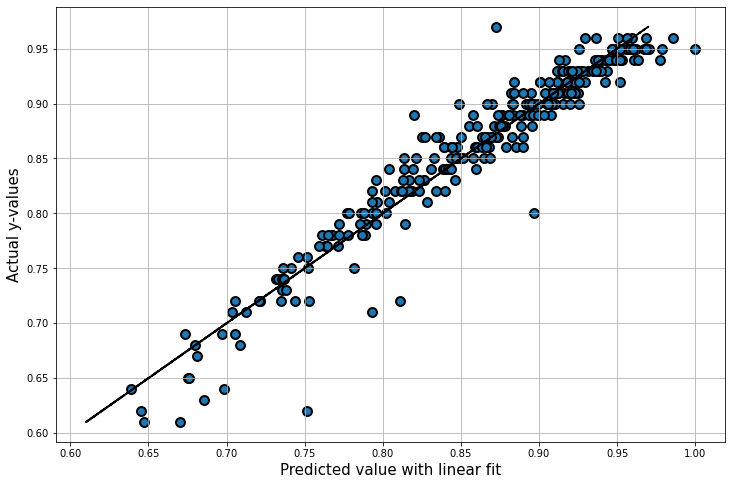

In [26]:
# f_in = '/Users/ksitterl/Documents/Python/watertap3/NAWI-WaterTAP3/IDAES-WaterTAP3_v2/data/old/evaporation_ratios.csv'
f_in = 'data/ratios.csv'
y_col = 'ratio'
degree = 2
air_temp = 4.4444
salinity = 100
humidity = 0.4
wind_speed = 2.7


poly_cost_curve(f_in, y_col, degree, air_temp, salinity, humidity, wind_speed, f_out='data/coeffs.csv', print_scores=True, print_eqn=True, plot_it=True, test_it=True)

In [27]:
def ratios(temp, salinity, humidity, wind_speed):
    x0 = temp
    x1 = salinity
    x2 = humidity
    x3 = wind_speed
    return 0.0181657227 * (x0) + 4.38801e-05 * (x1) + 0.2504964875 * (x2) + 0.011328485 * (x3) - 0.0003463853 * (x0 ** 2) - 2.16888e-05 * (x0 * x1) - 0.0181098164 * (x0 * x2) + 0.0002098163 * (x0 * x3) + 8.654e-07 * (x1 ** 2) - 0.0004358946 * (x1 * x2) - 8.73918e-05 * (x1 * x3) - 0.0165224935 * (x2 ** 2) - 0.0174278724 * (x2 * x3) + 0.0003850584 * (x3 ** 2) + 0.7943236298

In [35]:
temp_neg = []
salinity_neg = []
humidity_neg = []
wind_speed_neg = []
ratio_neg = []

temp_big = []
salinity_big = []
humidity_big = []
wind_speed_big = []
ratio_big = []

temp_norm = []
salinity_norm = []
humidity_norm = []
wind_speed_norm = []
ratio_norm = []




for temp in np.arange(4, 30, 0.1):
    for salinity in np.arange(50, 300, 5):
        for humidity in np.arange(0.4, 0.9, 0.02):
            for wind_speed in np.arange(1, 10, 0.1):
                ratio = ratios(temp, salinity, humidity, wind_speed)
                if ratio <= 0:
                    temp_neg.append(temp)
                    salinity_neg.append(salinity)
                    humidity_neg.append(humidity)
                    wind_speed_neg.append(wind_speed)
                    ratio_neg.append(ratio)
                
                if ratio >= 1:
                    temp_big.append(temp)
                    salinity_big.append(salinity)
                    humidity_big.append(humidity)
                    wind_speed_big.append(wind_speed)
                    ratio_big.append(ratio)

                else:
                    temp_norm.append(temp)
                    salinity_norm.append(salinity)
                    humidity_norm.append(humidity)
                    wind_speed_norm.append(wind_speed)
                    ratio_norm.append(ratio)


In [64]:
df = pd.read_csv('data/water_recovery.csv')
case_study_name = 'ashkelon'
unit_process_name = unit_process_type = 'reverse_osmosis'

if unit_process_type == 'reverse_osmosis':
    unit_process_type = 'ro_deep'  # until reverse osmosis is in table input
water_recovery_list  = df[df.unit_process == unit_process_type].case_study.to_list()
case_study_list = df[((df.unit_process == unit_process_type) & (df.case_study == case_study_name))].recovery
default_list = df[((df.unit_process == unit_process_type) & (df.case_study == 'default'))].recovery
test = df[((df.unit_process == unit_process_type) & (df.case_study == case_study_name))].recovery
if case_study_name in water_recovery_df:
    if 'calculated' not in case_study_list.max():
        flow_recovery_factor = float(case_study_list)
#         getattr(m.fs, unit_process_name).water_recovery.fix(flow_recovery_factor)
else:
    if 'calculated' not in default_list.max():
        flow_recovery_factor = float(default_list)
#         getattr(m.fs, unit_process_name).water_recovery.fix(flow_recovery_factor)

In [65]:
case_study_list

Series([], Name: recovery, dtype: object)

In [22]:
df = pd.read_csv('data/old/evaporation_ratios.csv')
# min(df.ratio)
# df = df[df.ratio >= 0.6]
# min(df.ratio)
# df.to_csv('ratios.csv')
ratios = df.ratio.to_list()
for i, ratio in enumerate(df.ratio.to_list()): 
    if ratio < 0.6:
        print(i + 2, ratio)

231 0.59
236 0.52
241 0.44
281 0.59
284 0.56
285 0.51
289 0.56
290 0.43
294 0.54
295 0.37
299 0.5
300 0.3


In [ ]:
def expand_cost_curve(df, flow_list, flow_min, flow_max, flow_inc, f_out):
    
    def power(x, a, b):
        return a * x ** b

    cost_curve = []
    df = df
#     print(df)
    dose_list = [10, 20, 50, 100, 200, 300, 500, 800, 1000]
    uvt_list = [0.55, 0.6, 0.65, 0.7, 0.75, 0.85, 0.9, 0.95]
    flow_list = flow_list
    big_sam = pd.DataFrame()
    for dose in dose_list:
        for uvt in uvt_list:
            sam = pd.DataFrame()
            temp = df[((df.uvt == uvt) & (df.dose == dose))]
#             print(temp)
            y = temp.cost.to_list()
            coeffs, _ = curve_fit(power, flow_list, y)
            flow_new = np.arange(flow_min, flow_max + flow_inc, flow_inc)
            cost_new = power(flow_new, *coeffs)
            sam['dose'] = pd.Series(dose)
            sam['uvt'] = pd.Series(uvt)
            sam['a'] = pd.Series(coeffs[0])
            sam['b'] = pd.Series(coeffs[1])
                                 
#             sam['flow_new'] = flow_new
            big_sam = big_sam.append(sam)
#             print(uvt)

    big_sam.to_csv(f_out, index=False)
    return temp

In [ ]:

df = pd.read_csv('data/uv_cost_twb.csv')
df_0 = df[(df.flow == 0)]
df_1 = df[(df.flow == 1)]
df_3 = df[(df.flow == 3)]
df_5 = df[(df.flow == 5)]
df_10 = df[(df.flow == 10)]
df_25 = df[(df.flow == 25)]

df_low = pd.concat([df_0, df_1, df_3, df_5])
df_high = pd.concat([df_0, df_5, df_10, df_25])


f_out = 'data/uv_coeffs.csv'
flow_list = [0, 1, 3, 5, 10, 25]
temp = expand_cost_curve(df, flow_list, 0, 5, 1, f_out)

# flow = 10
# dose = .100
# uvt = 0.7
# poly_cost_curve(f_out, 'cost', 4, flow, dose, uvt, print_scores=True, print_eqn=True, plot_it=True, test_it=True)

# x_new = np.arange(0, 51, 1)
# y_new = cats[((cats.uvt == uvt) & (cats.dose == dose))].cost.to_list()
# y_old = df[((df.uvt == uvt) & (df.dose == dose))].cost.to_list()
# plt.plot(flow_list, y_old, x_new, y_new)

In [ ]:
temp

df

In [ ]:
dose = 1000
uvt = 0.95
sam = pd.DataFrame()
y = temp.cost.to_list()
def power(x, a, b):
        return a * x ** b
coeffs, _ = curve_fit(power, flow_list, y)
flow_new = np.arange(0, 6, 1)
cost_new = power(flow_new, *coeffs)
# sam['cost_new'] = cost_new
sam['dose'] = pd.Series(dose)
sam['uvt'] = pd.Series(uvt)
sam['a'] = pd.Series(coeffs[0])
sam['b'] = pd.Series(coeffs[1])
# sam['flow_new'] = flow_new

In [ ]:
sam

In [ ]:
uv_dose = 20
uvt_in = 0.55

df = pd.read_csv('data/uv_coeffs.csv')
df = df[((df.uvt == uvt_in) & (df.dose == uv_dose))]
a = df.iloc[0]['a']
b = df.iloc[0]['b']

In [11]:
# brine concentrator
# cost = 15.1 + (tds_in * 3.02E-4) - (recovery * 18.8) + (flow_in * 8.08E-2)
tds_neg = []
recovery_neg = []
flow_neg = []
cost_neg = []
tds_big = []
recovery_big = []
flow_big = []
cost_big = []
tds_norm = []
recovery_norm = []
flow_norm = []
cost_norm = []
for tds in np.arange(10000, 500000, 1000):
    for recovery in np.arange(0.5, 0.99, 0.01):
        for flow in np.arange(1, 20001, 100):
            cost = 15.1 + (tds * 3.02E-4) - (recovery * 18.8) + (flow * 8.08E-2)
            if cost <= 0:
                cost_neg.append(cost)
                tds_neg.append(tds)
                recovery_neg.append(recovery)
                flow_neg.append(flow)
            #                 print(f'tds = {tds}\nrecovery = {recovery}\nflow = {flow}\n')

            else:
                cost_norm.append(cost)
                tds_norm.append(tds)
                recovery_norm.append(recovery)
                flow_norm.append(flow)
                

In [28]:
df = pd.DataFrame({'flow': flow_neg, 'tds': tds_neg, 'recovery': recovery_neg, 'cost': cost_neg})
df2 = pd.DataFrame({'flow': flow_norm, 'tds': tds_norm, 'recovery': recovery_norm, 'cost': cost_norm})

In [29]:
len(df2)
# len(df)

4890110

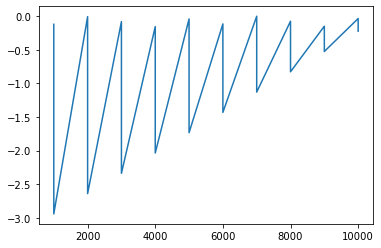

In [12]:
plt.plot(tds_neg, cost_neg)

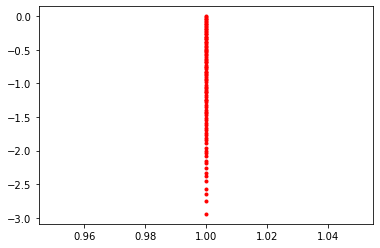

In [30]:
plt.plot(flow_neg, cost_neg, 'r.')

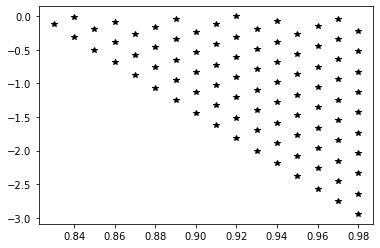

In [17]:
plt.plot(recovery_neg, cost_neg, 'k*')

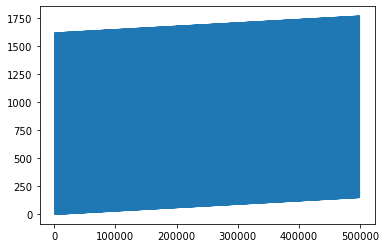

In [25]:
plt.plot(tds_norm, cost_norm)